In [1]:
import tensorflow as tf
import numpy as np
import glob
import os
import time
from sklearn import metrics
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

#tf.test.is_gpu_available()

In [3]:
"""
train_data_path = "train_data/"
total_data = []

for file_name in glob.glob(train_data_path+"x*_plus_bi.csv"):
  print(file_name)
  with open(file_name, "r") as file:
    data = np.loadtxt(file, delimiter=",")
  #print(data.shape)
  data = data.reshape([495, 100, -1])
  total_data.append(data)
  

total_data = np.array(total_data)
print(total_data.shape)

with open(train_data_path +"images_data.npy", "wb") as f:
    np.save(f, total_data)
"""

with open("./norm_images_data_dim_16.npy", "rb") as f:
  total_data = np.load(f)
print(total_data.shape)

(576, 495, 100, 16)


In [4]:
np.random.seed(7777)

rand_idx = np.arange(total_data.shape[0])

np.random.shuffle(rand_idx)

cut = total_data.shape[0]//8

test_data = total_data[rand_idx[:cut]]
train_data = total_data[rand_idx[cut:]]

print(test_data.shape)
print(train_data.shape)

train_X = train_data[:, :, :, :-1]
train_Y = train_data[:, :, :, -1:]
test_X = test_data[:, :, :, :-1]
test_Y = test_data[:, :, :, -1:]

total_epochs = 250
batch_size = 10
units = 128
resnet_mode = "resnet34_less_unit"
step_per_epoch = (train_X.shape[0]+batch_size-1)//batch_size

(72, 495, 100, 16)
(504, 495, 100, 16)


In [5]:
"""
for idx in range(test_X.shape[0]):

  fig = plt.figure(num=0, clear=True, figsize=[50, 10])
  ax = plt.subplot(1, 1, 1)

  cells = test_X[idx]
  print(cells.shape)
  cells = cells.reshape([-1, cells.shape[-1]])
  colors = np.zeros([cells.shape[0], 3])

  reds = test_Y[idx].flatten() > 0
  print(test_Y.shape )
  colors[reds] = [1.0, 0.0, 0.0]
  
  plt.scatter(cells[:, 4], cells[:, 5], s=15, color = colors,)
  
    
  
  plt.tight_layout()
  plt.xlim([0.0, 5.0])
  plt.ylim([0.0, 1.0])
  #plt.savefig("./real_resnet_result/"+f"x={cells[0,0]:.4f}y={cells[0,1]:.4f}pr={cells[0,2]:.4f}_fig.png")
  plt.show()
"""

'\nfor idx in range(test_X.shape[0]):\n\n  fig = plt.figure(num=0, clear=True, figsize=[50, 10])\n  ax = plt.subplot(1, 1, 1)\n\n  cells = test_X[idx]\n  print(cells.shape)\n  cells = cells.reshape([-1, cells.shape[-1]])\n  colors = np.zeros([cells.shape[0], 3])\n\n  reds = test_Y[idx].flatten() > 0\n  print(test_Y.shape )\n  colors[reds] = [1.0, 0.0, 0.0]\n  \n  plt.scatter(cells[:, 4], cells[:, 5], s=15, color = colors,)\n  \n    \n  \n  plt.tight_layout()\n  plt.xlim([0.0, 5.0])\n  plt.ylim([0.0, 1.0])\n  #plt.savefig("./real_resnet_result/"+f"x={cells[0,0]:.4f}y={cells[0,1]:.4f}pr={cells[0,2]:.4f}_fig.png")\n  plt.show()\n'

In [6]:
class Batcher:
    def __init__(self, x, y, randomize = False):
        self.test_x = x
        self.test_y = y
        self.test_random_idx = None
        self.test_random = randomize
    
    def get_batch(self, batch_size):
        def shuffle_idx(x):
            if (self.test_random):
                np.random.shuffle(x)
        
        if (self.test_random_idx is None):
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        inp = []
        targ = []
        while (batch_size > self.test_random_idx.shape[0]):
            inp.append(self.test_x[self.test_random_idx])
            targ.append(self.test_y[self.test_random_idx])
            batch_size -= self.test_random_idx.shape[0]
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        inp.append(self.test_x[self.test_random_idx[:batch_size]])
        targ.append(self.test_y[self.test_random_idx[:batch_size]])
        if (self.test_random_idx.shape[0] - batch_size == 0):
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        else :
            self.test_random_idx = self.test_random_idx[batch_size:]
        inp = np.concatenate(inp, axis = 0)
        targ = np.concatenate(targ, axis = 0)
        return inp, targ
    def reset_random(self):
        self.test_random_idx = None

In [7]:
train_batcher = Batcher(train_X, train_Y, randomize=True)
test_batcher = Batcher(test_X, test_Y, randomize=False )

In [8]:
class ResidualBlock(tf.keras.layers.Layer):
  def __init__(self, unit, kernel_size = 3, diff_dim = False):
    super(ResidualBlock, self).__init__()

    self.unit = unit
    self.kernel_size = kernel_size
    self.diff_dim = diff_dim
    
    
    self.c1 = tf.keras.layers.Conv2D(self.unit, self.kernel_size,
                                    padding = "same",
                                    kernel_initializer="he_normal"
                                    )
    self.b_norm1 = tf.keras.layers.BatchNormalization()
    self.c2 = tf.keras.layers.Conv2D(self.unit, self.kernel_size,
                                    padding = "same",
                                    kernel_initializer="he_normal"
                                    )
    self.b_norm2 = tf.keras.layers.BatchNormalization()

    if self.diff_dim:
        self.c1_b = tf.keras.layers.Conv2D(self.unit, 1,
                                    padding = "same",
                                    kernel_initializer="he_normal"
                                    )
        self.b_norm1_b = tf.keras.layers.BatchNormalization()
    
  def call(self, x, training):
    y = x
    y = self.c1(y)
    y = self.b_norm1(y, training=training)
    y = tf.nn.relu(y)
    y = self.c2(y)
    y = self.b_norm2(y, training=training)
    if self.diff_dim:
        y_b = x
        y_b = self.c1_b(y_b)
        y_b = self.b_norm1_b(y_b)
        y = y + y_b
    else:
        y = x + y
    return y
  

class My_CNN(tf.keras.Model):
  def __init__(self, unit=16, resnet_mode = "resnet34"):
    super(My_CNN, self).__init__()
    
    self.unit = unit
    
    #self.b_norm1 = tf.keras.layers.BatchNormalization()
    
    self.c1 = tf.keras.layers.Conv2D(self.unit, (7, 7),
                                    padding = "same",
                                    kernel_initializer="he_normal")
    
    self.b_norm2 = tf.keras.layers.BatchNormalization()
    
    self.res_layers = []
    
    if resnet_mode == "resnet18":
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit*2, 3, diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*2, 3))
        self.res_layers.append(ResidualBlock(unit*4, 3, diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*4, 3))
        self.res_layers.append(ResidualBlock(unit*8, 3, diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*8, 3))
    elif resnet_mode == "resnet18_alter":
        self.res_layers.append(ResidualBlock(unit, (9, 3) ))
        self.res_layers.append(ResidualBlock(unit, (9, 3) ))
        self.res_layers.append(ResidualBlock(unit*2, (9, 3), diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*2, (9, 3)))
        self.res_layers.append(ResidualBlock(unit*4, (9, 3), diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*4, (9, 3)))
        self.res_layers.append(ResidualBlock(unit*8, (9, 3), diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*8, (9, 3)))
    elif resnet_mode == "resnet34":
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit*2, 3, diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*2, 3))
        self.res_layers.append(ResidualBlock(unit*2, 3))
        self.res_layers.append(ResidualBlock(unit*2, 3))
        self.res_layers.append(ResidualBlock(unit*4, 3, diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*4, 3))
        self.res_layers.append(ResidualBlock(unit*4, 3))
        self.res_layers.append(ResidualBlock(unit*4, 3))
        self.res_layers.append(ResidualBlock(unit*4, 3))
        self.res_layers.append(ResidualBlock(unit*4, 3))
        self.res_layers.append(ResidualBlock(unit*8, 3, diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*8, 3))
        self.res_layers.append(ResidualBlock(unit*8, 3))
    elif resnet_mode == "resnet34_alter":
        self.res_layers.append(ResidualBlock(unit, (9, 3)))
        self.res_layers.append(ResidualBlock(unit, (9, 3)))
        self.res_layers.append(ResidualBlock(unit, (9, 3)))
        self.res_layers.append(ResidualBlock(unit*2, (9, 3), diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*2, (9, 3)))
        self.res_layers.append(ResidualBlock(unit*2, (9, 3)))
        self.res_layers.append(ResidualBlock(unit*2, (9, 3)))
        self.res_layers.append(ResidualBlock(unit*4, (9, 3), diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*4, (9, 3)))
        self.res_layers.append(ResidualBlock(unit*4, (9, 3)))
        self.res_layers.append(ResidualBlock(unit*4, (9, 3)))
        self.res_layers.append(ResidualBlock(unit*4, (9, 3)))
        self.res_layers.append(ResidualBlock(unit*4, (9, 3)))
        self.res_layers.append(ResidualBlock(unit*8, (9, 3), diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*8, (9, 3)))
        self.res_layers.append(ResidualBlock(unit*8, (9, 3)))
    elif resnet_mode == "resnet34_less_unit":
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit*2, 3, diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*2, 3))
        self.res_layers.append(ResidualBlock(unit*2, 3))
        self.res_layers.append(ResidualBlock(unit*2, 3))
        self.res_layers.append(ResidualBlock(unit*3, 3, diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*3, 3))
        self.res_layers.append(ResidualBlock(unit*3, 3))
        self.res_layers.append(ResidualBlock(unit*3, 3))
        self.res_layers.append(ResidualBlock(unit*3, 3))
        self.res_layers.append(ResidualBlock(unit*3, 3))
        self.res_layers.append(ResidualBlock(unit*4, 3, diff_dim = True))
        self.res_layers.append(ResidualBlock(unit*4, 3))
        self.res_layers.append(ResidualBlock(unit*4, 3))
    elif resnet_mode == "resnet34_same_unit":
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
        self.res_layers.append(ResidualBlock(unit, 3))
    else:
        raise NotImplementedError(f"invalid resnet mode: {resnet_mode}")
    
    
    self.f = tf.keras.layers.Conv2D(1, (1, 1),
                                  #activation="sigmoid"
                                   )

  def call(self, x, training = False):
    y = x
    #y = self.b_norm1(y, training = training)
    y = self.c1(y)
    y = self.b_norm2(y, training = training)
    
    for ly in self.res_layers:
      y = ly(y, training = training)
    y = self.f(y)
    return y




In [9]:
type([]) == list()

False

In [10]:

learning_rate = 0.00005

model = My_CNN(units, resnet_mode=resnet_mode)
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                reduction="none")
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum=0.9)

checkpoint_dir = "./ckpt/real_resnet_"+f"u={units}_{resnet_mode}_for_training"
checkpoint_prefix = os.path.join(checkpoint_dir, "tf")
checkpoint = tf.train.Checkpoint(model=model,
                                 optimizer = optimizer
                                )

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))



@tf.function
def training_step(inp, targ):
  with tf.GradientTape() as tape:
    pred = model(inp, training = True)
    #print(pred[0])
    loss = tf.reduce_mean(loss_object(targ, pred))
  variables = model.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  
  return loss

def validation():
  test_step = test_X.shape[0] // batch_size
  test_batcher.reset_random()
  total_loss = 0
  total_pred = []
  total_targ = []
  for i_step in range(test_step):
    inp, targ = test_batcher.get_batch(batch_size)
    pred = model(inp, training = False)
    loss = loss_object(targ, pred).numpy()
    loss = np.mean(loss.reshape([batch_size, -1]), axis=-1)
    loss = np.sum(loss)
    total_loss += loss
    total_pred.append(pred.numpy())
    total_targ.append(targ)
  if (test_X.shape[0] - (i_step+1) * batch_size) > 0:
    inp, targ = test_batcher.get_batch((test_X.shape[0] - (i_step+1) * batch_size))
    pred = model(inp, training = False)
    loss = loss_object(targ, pred).numpy()
    loss = np.mean(loss.reshape([batch_size, -1]), axis=-1)
    loss = np.sum(loss)
    total_loss += loss
    total_pred.append(pred.numpy())
    total_targ.append(targ)
    
  total_loss /= test_X.shape[0]
  
  total_pred = np.concatenate(total_pred, axis=0)
  total_targ = np.concatenate(total_targ, axis=0)
  
  total_pred_flat = total_pred.flatten()
  total_targ_flat = total_targ.flatten()
  
  fpr, tpr, thresholds = metrics.roc_curve(total_targ_flat, total_pred_flat, pos_label=1)
  auc = metrics.auc(fpr, tpr)
  
  return total_loss, auc

2023-03-03 21:37:03.354405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 21:37:04.047372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46722 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


In [ ]:
train_losses = []
val_losses = []

val_aucs = []

for ep in range(total_epochs):
  train_batcher.reset_random()
  total_loss = 0
  start = time.time()
  for i_step in range(step_per_epoch):
    inp, targ = train_batcher.get_batch(batch_size)
    loss = training_step(inp, targ)
    total_loss += loss

    if (i_step+1) % 10 == 0:
      print(f"Epoch {ep} Step {i_step+1} Loss: {loss.numpy():.4f}")
  total_loss /= step_per_epoch
  print(f"Time taken for 1 epoch {time.time()-start} sec")
  print(f"Epoch {ep} Loss: {total_loss.numpy():.4f}")
  train_losses.append(total_loss)
  
  val_loss, val_auc = validation()
  
  print(f"Validation Loss: {val_loss:.4f}")
  
  checkpoint.save(file_prefix=checkpoint_prefix)
  
  val_losses.append(val_loss)
  val_aucs.append(val_auc)
  
import matplotlib.pyplot as plt

plt.figure(figsize = [10, 6])
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="validation_loss")
plt.xlabel("epoch")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()

np.save(checkpoint_dir+"/train_losses.npy", train_losses)
np.save(checkpoint_dir+"/val_losses.npy", val_losses)

plt.figure(figsize = [10, 7])
plt.plot(val_aucs, label="val_auc")
plt.legend()
plt.show()

2023-03-03 21:37:06.867388: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2023-03-03 21:37:11.244807: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.91GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-03 21:37:11.244853: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.99GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-03 21:37:11.244866: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

Epoch 0 Step 10 Loss: 1.0429
Epoch 0 Step 20 Loss: 0.8687
Epoch 0 Step 30 Loss: 0.7937
Epoch 0 Step 40 Loss: 0.7667
Epoch 0 Step 50 Loss: 0.7246
Time taken for 1 epoch 261.7851881980896 sec
Epoch 0 Loss: 0.8753


2023-03-03 21:41:25.955720: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Validation Loss: 23.5818
Epoch 1 Step 10 Loss: 0.7025
Epoch 1 Step 20 Loss: 0.6860
Epoch 1 Step 30 Loss: 0.6700
Epoch 1 Step 40 Loss: 0.6539
Epoch 1 Step 50 Loss: 0.6471
Time taken for 1 epoch 230.67207407951355 sec
Epoch 1 Loss: 0.6828
Validation Loss: 3.5076
Epoch 2 Step 10 Loss: 0.6577
Epoch 2 Step 20 Loss: 0.6266
Epoch 2 Step 30 Loss: 0.6025
Epoch 2 Step 40 Loss: 0.6131
Epoch 2 Step 50 Loss: 0.5900
Time taken for 1 epoch 230.57619905471802 sec
Epoch 2 Loss: 0.6182
Validation Loss: 1.3732
Epoch 3 Step 10 Loss: 0.5934
Epoch 3 Step 20 Loss: 0.5983
Epoch 3 Step 30 Loss: 0.5676
Epoch 3 Step 40 Loss: 0.5723
Epoch 3 Step 50 Loss: 0.5412
Time taken for 1 epoch 230.68157243728638 sec
Epoch 3 Loss: 0.5709
Validation Loss: 0.8620
Epoch 4 Step 10 Loss: 0.5362
Epoch 4 Step 20 Loss: 0.5473
Epoch 4 Step 30 Loss: 0.5331
Epoch 4 Step 40 Loss: 0.5230
Epoch 4 Step 50 Loss: 0.5122
Time taken for 1 epoch 230.63619565963745 sec
Epoch 4 Loss: 0.5330
Validation Loss: 0.6827
Epoch 5 Step 10 Loss: 0.5092
Ep

Epoch 35 Step 20 Loss: 0.1635
Epoch 35 Step 30 Loss: 0.1775
Epoch 35 Step 40 Loss: 0.1636
Epoch 35 Step 50 Loss: 0.1677
Time taken for 1 epoch 230.69556736946106 sec
Epoch 35 Loss: 0.1681
Validation Loss: 0.1852
Epoch 36 Step 10 Loss: 0.1765
Epoch 36 Step 20 Loss: 0.1584
Epoch 36 Step 30 Loss: 0.1614
Epoch 36 Step 40 Loss: 0.1578
Epoch 36 Step 50 Loss: 0.1648
Time taken for 1 epoch 230.58662009239197 sec
Epoch 36 Loss: 0.1643
Validation Loss: 0.1780
Epoch 37 Step 10 Loss: 0.1592
Epoch 37 Step 20 Loss: 0.1669
Epoch 37 Step 30 Loss: 0.1546
Epoch 37 Step 40 Loss: 0.1569
Epoch 37 Step 50 Loss: 0.1725
Time taken for 1 epoch 230.71514129638672 sec
Epoch 37 Loss: 0.1615
Validation Loss: 0.1767
Epoch 38 Step 10 Loss: 0.1578
Epoch 38 Step 20 Loss: 0.1534
Epoch 38 Step 30 Loss: 0.1537
Epoch 38 Step 40 Loss: 0.1633
Epoch 38 Step 50 Loss: 0.1504
Time taken for 1 epoch 230.6670331954956 sec
Epoch 38 Loss: 0.1574
Validation Loss: 0.1765
Epoch 39 Step 10 Loss: 0.1591
Epoch 39 Step 20 Loss: 0.1488
Epo

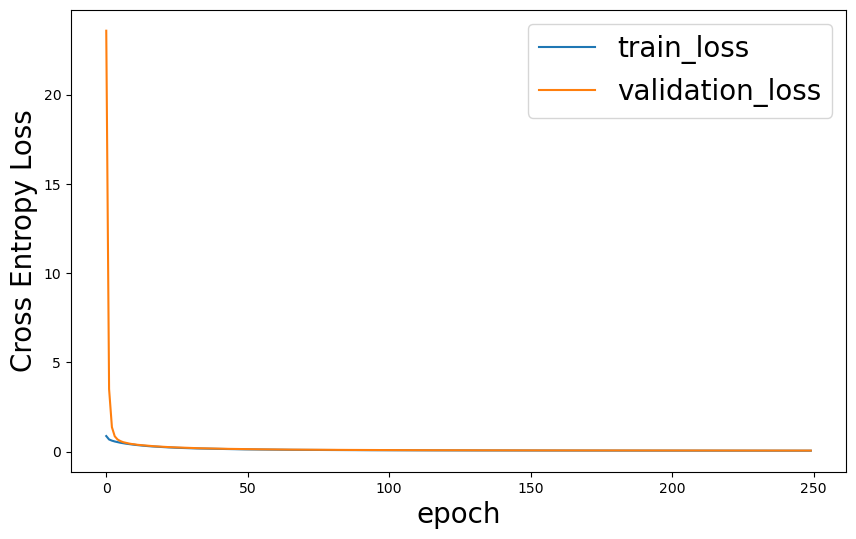

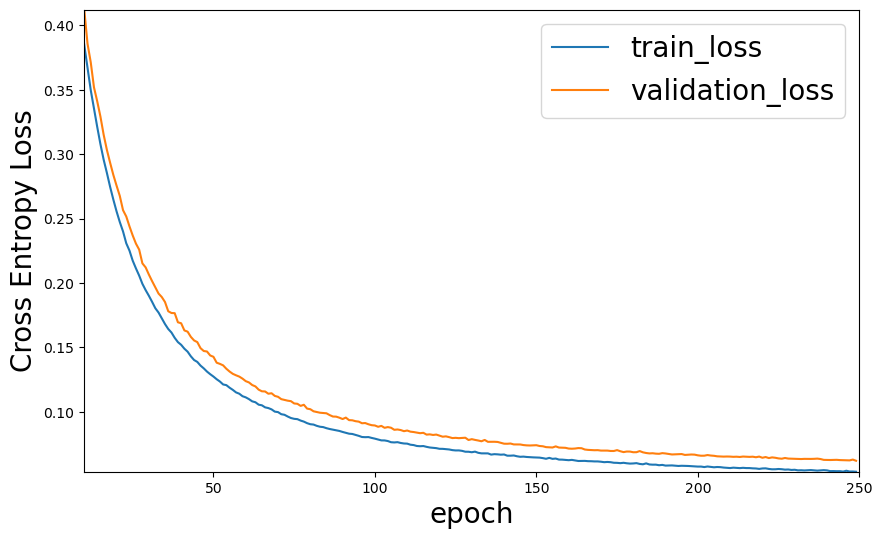

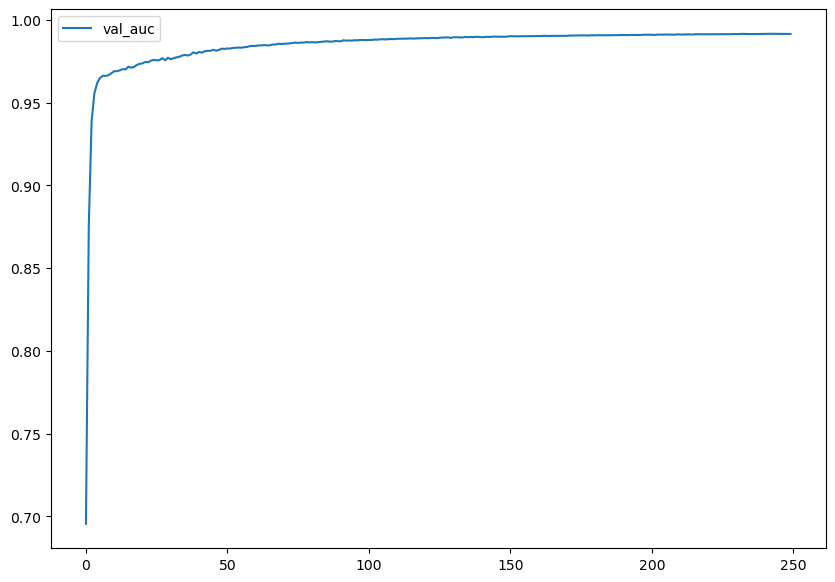

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize = [10, 6])
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="validation_loss")
plt.xlabel("epoch", fontsize=20)
plt.ylabel("Cross Entropy Loss", fontsize=20)
plt.legend(fontsize=20)
plt.show()

plt.figure(figsize = [10, 6])
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="validation_loss")
start_at = 10
plt.xlim([start_at, 250])
plt.ylim([np.min(train_losses[start_at:]), np.max(val_losses[start_at:])])
plt.xlabel("epoch", fontsize=20)
plt.ylabel("Cross Entropy Loss", fontsize=20)
plt.legend(fontsize=20)
plt.show()

np.save(checkpoint_dir+"/train_losses.npy", train_losses)
np.save(checkpoint_dir+"/val_losses.npy", val_losses)

plt.figure(figsize = [10, 7])
plt.plot(val_aucs, label="val_auc")
plt.legend()
plt.show()

In [ ]:

test_step = test_X.shape[0] // batch_size
test_batcher.reset_random()
total_loss = 0
total_test_inp = []
total_pred = []
total_targ = []
for i_step in range(test_step):
  inp, targ = test_batcher.get_batch(batch_size)
  pred = model(inp, training = False)
  loss = loss_object(targ, pred).numpy()
  loss = np.mean(loss.reshape([batch_size, -1]), axis=-1)
  loss = np.sum(loss)
  total_loss += loss
  total_pred.append(pred.numpy())
  total_targ.append(targ)
if (test_X.shape[0] - (i_step+1) * batch_size) > 0:
  inp, targ = test_batcher.get_batch((test_X.shape[0] - (i_step+1) * batch_size))
  pred = model(inp, training = False)
  loss = loss_object(targ, pred).numpy()
  loss = np.mean(loss.reshape([batch_size, -1]), axis=-1)
  loss = np.sum(loss)
  total_loss += loss
  total_pred.append(pred.numpy())
  total_targ.append(targ)

total_loss /= test_X.shape[0]

total_pred = np.concatenate(total_pred, axis=0)
total_targ = np.concatenate(total_targ, axis=0)

total_pred_flat = total_pred.flatten()
total_targ_flat = total_targ.flatten()

fpr, tpr, thresholds = metrics.roc_curve(total_targ_flat, total_pred_flat, pos_label=1)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel("False-positive rate")
plt.ylabel("True-positive rate")
plt.tight_layout()

plt.show()

(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
(495, 100, 30)
(495, 100, 1)
acc: 0.9788888888888889


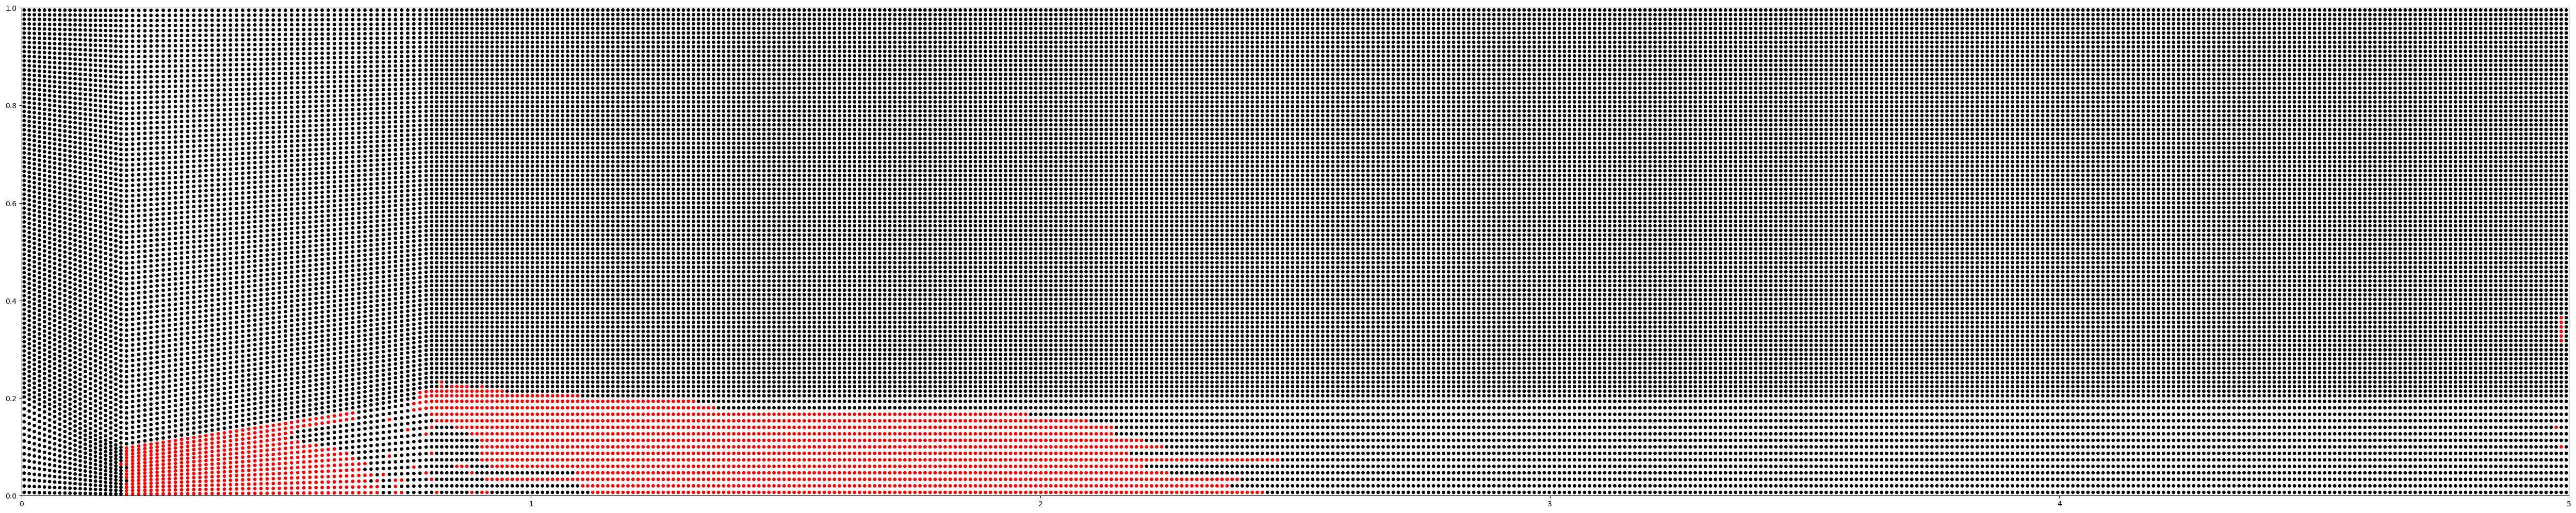

In [14]:

hits = 0
trials = 0

with open("./test_data/images_data.npy", "rb") as f:
  xys = np.load(f)

fig_path = f"./test_resnet_"+f"u={units}_{resnet_mode}_result/"

if not os.path.exists(fig_path):
    os.mkdir(fig_path)

for idx in range(test_X.shape[0]):

  fig = plt.figure(num=0, clear=True, figsize=[50, 10])
  ax = plt.subplot(1, 1, 1)

  cells = xys[idx]
  print(cells.shape)
  cells = cells.reshape([-1, cells.shape[-1]])
  colors = np.zeros([cells.shape[0], 3])
  total_pred_flat = total_pred[idx].flatten()
  sorted_pred = np.sort(total_pred_flat)
  thres = sorted_pred[-np.size(total_pred_flat)//20]
  reds = total_pred_flat > thres
  
  #reds = total_targ[idx].flatten() > 0
  #reds = test_Y[idx].flatten() > 0
  print(total_targ[idx].shape)
  
  trials += np.size(total_targ[idx])
  hits += np.sum(total_targ[idx].flatten() == reds)
  
  
  colors[reds] = [1.0, 0.0, 0.0]
  
  plt.scatter(cells[:, 4], cells[:, 5], s=15, color = colors,)
  
    
  
  plt.tight_layout()
  plt.xlim([0.0, 5.0])
  plt.ylim([0.0, 1.0])
  
  plt.savefig(fig_path+f"x={cells[0,0]:.4f}y={cells[0,1]:.4f}pr={cells[0,2]:.4f}_fig.png")
  #plt.show()
  #assert False

  file_journal = open("resnet_refi_jour/"+f"x={cells[0,0]:.4f}y={cells[0,1]:.4f}pr={cells[0,2]:.4f}.txt", "w")
  for r in range(xys.shape[1]):
    for c in range(xys.shape[2]):
      if reds[r*100+c]:
          triangle = xys[idx, r, c, -8:].reshape([-1, 2])

          file_journal.write("/adapt/mir yes no")
          file_journal.write(" %.8f" % np.min(triangle[:, 0]))
          file_journal.write(" %.8f" % np.max(triangle[:, 0]))
          file_journal.write(" %.8f" % np.min(triangle[:, 1]))
          file_journal.write(" %.8f\n" % np.max(triangle[:, 1]))
          file_journal.write("/adapt/adapt-to-register 0 0 0 yes\n")
  file_journal.close()
print("acc:", hits / trials)

In [ ]:
# u=32 "resnet34": 0.9763002244668911
# u=32 "bn resnet18-alter": 0.9742525252525253

#new data
# u=32 "resnet18-alter" : 0.9761773288439956
# u=32 "resnet34" bsz=24: 0.9768468013468014
# u=32 "resnet34_alter" bsz=20: 0.976648709315376
# u=48 "resnet34" bsz=16: 0.9779281705948373
# u=64 "resnet34" bsz=10: 0.9791099887766554
# u=128 "resnet34_less_unit" bsz=10: 0.9799130190796858

In [11]:

test_data_path = "test_data/"
total_data = []

for file_name in glob.glob(test_data_path+"x*_plus_bi.csv"):
  print(file_name)
  with open(file_name, "r") as file:
    data = np.loadtxt(file, delimiter=",")
  #print(data.shape)
  data = data.reshape([495, 100, -1])
  total_data.append(data)
  

total_data = np.array(total_data)
print(total_data.shape)

with open(test_data_path +"images_data.npy", "wb") as f:
    np.save(f, total_data)


#with open("./norm_images_data_dim_16.npy", "rb") as f:
#  total_data = np.load(f)
#print(total_data.shape)

test_data/x=700y=244.9489743pr=0.016-c.cas.geo_plus_bi.csv
test_data/x=800y=244.9489743pr=0.016-c.cas.geo_plus_bi.csv
test_data/x=500y=282.8427125pr=0.2-c.cas.geo_plus_bi.csv
test_data/x=500y=244.9489743pr=0.016-c.cas.geo_plus_bi.csv
test_data/x=600y=282.8427125pr=0.2-c.cas.geo_plus_bi.csv
test_data/x=700y=200pr=0.01-c.cas.geo_plus_bi.csv
test_data/x=600y=200pr=0.01-c.cas.geo_plus_bi.csv
test_data/x=700y=282.8427125pr=0.2-c.cas.geo_plus_bi.csv
test_data/x=500y=200pr=0.01-c.cas.geo_plus_bi.csv
test_data/x=600y=244.9489743pr=0.016-c.cas.geo_plus_bi.csv
test_data/x=800y=282.8427125pr=0.2-c.cas.geo_plus_bi.csv
test_data/x=900y=200pr=0.01-c.cas.geo_plus_bi.csv
test_data/x=400y=200pr=0.01-c.cas.geo_plus_bi.csv
test_data/x=400y=244.9489743pr=0.016-c.cas.geo_plus_bi.csv
test_data/x=900y=282.8427125pr=0.2-c.cas.geo_plus_bi.csv
test_data/x=400y=282.8427125pr=0.2-c.cas.geo_plus_bi.csv
test_data/x=900y=244.9489743pr=0.016-c.cas.geo_plus_bi.csv
test_data/x=800y=200pr=0.01-c.cas.geo_plus_bi.csv
(18,

In [12]:
with open("./test_norm_images_data_dim_16.npy", "rb") as f:
  test_data = np.load(f)

test_X = test_data[:, :, :, :-1]
test_Y = test_data[:, :, :, -1:]

In [15]:
total_pred[idx].shape

(495, 100, 1)

In [1]:
a = np.array([[[1,2, 3], [4, 5, 6]], [[7, 8, 9],[10, 11, 12]]])

print(a)
print(a.shape)

print(a[:, -1].flatten())

print(a.reshape((-1, 3)))

NameError: name 'np' is not defined

In [12]:
checkpoint.save(file_prefix=checkpoint_prefix)

'./ckpt/resnet_u=64_l=12\\tf-1'

In [22]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))